# the purpose of this analysis is to use transfermarkt data to answer the following question:

Question 1) Can we measure the impact of single players on the outcome of a game by comparing the success rate / win rate with them on the pitch and without them on the pitch and like that identify the players that make a team better or at least more successful

In [277]:
#import relevant libraries
#read in data files

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df_app = pd.read_csv('Data Files/appearances.csv')
df_club_games = pd.read_csv('Data Files/club_games.csv')
df_clubs = pd.read_csv('Data Files/clubs.csv')
df_competitions = pd.read_csv('Data Files/competitions.csv')
df_game_events = pd.read_csv('Data Files/game_events.csv')
df_games = pd.read_csv('Data Files/games.csv')
df_player_val = pd.read_csv('Data Files/player_valuations.csv')
df_players = pd.read_csv('Data Files/players.csv')

In [278]:
# Merge df_players and df_app based on player_id
merged_df = pd.merge(df_players, df_app, on='player_id', how='outer')

# Merge df_players_app and df_games based on game_id
merged_df = pd.merge(merged_df, df_games, on='game_id', how='outer')

# Remove duplicates
merged_df = merged_df.drop_duplicates()

In [279]:
#create a dataframe per player that shows the contract start and end date with a club
#to simplify and due to missing contract data we will assume the contract of a player with a club starts with
#his first game and ends with his last game for a specific club

#create subset with player, club, game info and the date for the game from the merged dataset
contract_df = merged_df[['player_id', 'date_x', 'game_id', 'player_club_id']]
contract_df = contract_df.dropna()

#transform date column into date type
contract_df['date_x'] = pd.to_datetime(contract_df['date_x'])

#find the contract start 
contract_df_min = contract_df.groupby(['player_id', 'player_club_id'])['date_x'].min()
#find the contract start end
contract_df_max = contract_df.groupby(['player_id', 'player_club_id'])['date_x'].max()

# Convert the Series back to a DataFrame
contract_df_min = contract_df_min.reset_index()
contract_df_min = contract_df_min.rename(columns={'date_x': 'contract_start'})
contract_df_max = contract_df_max.reset_index()
contract_df_max = contract_df_max.rename(columns={'date_x': 'contract_end'})

# Merge contract_max to contract start
contract_df = pd.merge(contract_df_min, contract_df_max, on=['player_id', 'player_club_id'], how='outer')

#change contract df columns player id and player club id to integers
contract_df["player_id"] = contract_df["player_id"].astype(int)
contract_df["player_club_id"] = contract_df["player_club_id"].astype(int)

In [280]:
#merge contract information on club game data
df_player_games = pd.merge(contract_df, df_club_games, left_on = 'player_club_id', right_on= 'club_id')
df_player_games = pd.merge(df_player_games, df_games[['game_id', 'date']], on= 'game_id')

#set date column to datetime
df_player_games['date'] = pd.to_datetime(df_player_games['date'])

In [281]:
#check if player was an active team member during the game
df_player_games['was_team_member'] = df_player_games.apply(lambda row: 1 if row['contract_start'] 
                                                                 <= row['date'] <= row['contract_end'] 
                                                                 else 0, axis=1)

#filter for all the games where the player was an active member of team
df_player_games = df_player_games[df_player_games["was_team_member"] == 1]

In [282]:
#function for deriving the result of the game
def calculate_results (own_goals, opp_goals):
    if own_goals > opp_goals:
        result = 'w'
    elif own_goals == opp_goals:
        result = 'd'
    else:
        result = 'l'
    return result

#apply function
df_player_games["result"] = df_player_games.apply(lambda row: calculate_results (row['own_goals'], 
                                                                                row['opponent_goals']),
                                                               axis=1)

In [283]:
#create new dataframe for only the games that a player has actually played
df_player_games_played = pd.merge(df_app, df_club_games, left_on=['game_id', 'player_club_id'],
                                  right_on=['game_id', 'club_id'])

#apply result function
df_player_games_played["result"] = df_player_games_played.apply(lambda row: calculate_results (row['own_goals'], 
                                                                                row['opponent_goals']),
                                                               axis=1)

In [284]:
#add season information to the dataframes
df_player_games = pd.merge(df_player_games, df_games[['game_id', 'season']], on='game_id')
df_player_games_played = pd.merge(df_player_games_played, df_games[['game_id', 'season']], on='game_id')

In [285]:
# Create a pivot table to count the results per player in the matches he has played
player_results_per_season = df_player_games_played.pivot_table(index=['player_id', 'season', 'club_id'], columns='result', aggfunc='size', fill_value=0)

# Rename columns
player_results_per_season.columns = ['draws_in_matches_played', 'losses_in_matches_played', 'wins_in_matches_played']

# Reset index to make 'player_id' a regular column
player_results_per_season.reset_index(inplace=True)

# Create a pivot table to count the results per player in the matches he has played
team_results_per_season = df_player_games.pivot_table(index=['player_id', 'season', 'club_id'], columns='result', aggfunc='size', fill_value=0)

# Rename columns
team_results_per_season.columns = ['draws_in_matches_overall', 'losses_in_matches_overall', 'wins_in_matches_overall']

# Reset index to make 'player_id' a regular column
team_results_per_season.reset_index(inplace=True)

In [286]:
merged_results = pd.merge(team_results_per_season, player_results_per_season, on = ["player_id", "season", "club_id"])

In [287]:
#get results for matches that player didnt play but was in the team
merged_results['wins_in_matches_not_played'] = merged_results['wins_in_matches_overall']-merged_results['wins_in_matches_played']
    
merged_results['draws_in_matches_not_played'] = merged_results['draws_in_matches_overall']-merged_results['draws_in_matches_played']
    
merged_results['losses_in_matches_not_played'] = merged_results['losses_in_matches_overall']-merged_results['losses_in_matches_played']

columns_to_drop = ['draws_in_matches_overall', 'losses_in_matches_overall', 'wins_in_matches_overall']
merged_results = merged_results.drop(columns= columns_to_drop, axis=1)

merged_results["games_on_pitch"] = merged_results["draws_in_matches_played"]+merged_results["losses_in_matches_played"]+merged_results["wins_in_matches_played"]
merged_results["games_off_pitch"] = merged_results["draws_in_matches_not_played"]+merged_results["losses_in_matches_not_played"]+merged_results["wins_in_matches_not_played"]

#calculate the win rate when a player was playing vs the win rate when the player was not playing
merged_results["win_rate_on_pitch"] = merged_results["wins_in_matches_played"]/merged_results["games_on_pitch"]
merged_results["win_rate_off_pitch"] = merged_results["wins_in_matches_not_played"]/merged_results["games_off_pitch"]

#calculate the delta of the two win rates
merged_results["win_rate_delta_on_off_pitch"] = merged_results["win_rate_on_pitch"] - merged_results["win_rate_off_pitch"]

#calculate overall win rate of the team
merged_results['win_rate_overall'] = (merged_results['wins_in_matches_not_played']+merged_results['wins_in_matches_played'])/(merged_results['games_on_pitch']+merged_results['games_off_pitch'])


In [288]:
#enrich dataset with additional information
merged_results = pd.merge(merged_results, df_players[['player_id', 'name', 'position']], on='player_id')
merged_results = pd.merge(merged_results, df_clubs[['club_id', 'name']], on='club_id')
merged_results = pd.merge(merged_results, df_players[['player_id', 'country_of_birth', 'height_in_cm', 'date_of_birth']], on='player_id')

#rename the columns
merged_results = merged_results.rename(columns={'name_x': 'name'})
merged_results = merged_results.rename(columns={'name_y': 'club name'})

#change column to datetime
merged_results['date_of_birth'] = pd.to_datetime(merged_results['date_of_birth'])

#get birthyear
merged_results['birth_year'] = merged_results['date_of_birth'].dt.year

#derive the age in the specific season of the player
merged_results['age_in_season'] = merged_results['season'] - merged_results['birth_year']

In [289]:
#preparation of player valuation on a saison basis - valuation date is the last valuation before August each year
df_player_val["date"] = pd.to_datetime(df_player_val["date"])
df_player_val["year"] = df_player_val["date"].dt.year
df_player_val["month"] = df_player_val["date"].dt.month
df_player_val = df_player_val[df_player_val["month"]<8]
df_player_val["season"] =df_player_val["year"] - 1

df_val_agg = df_player_val.groupby(['player_id', 'season']).agg({'date': 'max'}).reset_index()
df_val_agg = pd.merge(df_val_agg, df_player_val[["date", "player_id", "market_value_in_eur"]], on=["player_id", "date"], how="inner")

#merge valuation data with merged results
merged_results = pd.merge(merged_results, df_val_agg[["player_id", "season", "market_value_in_eur"]], 
                      on=["player_id", "season"])

In [290]:
#we filter just for players that have played in at least 15 games in a season
merged_results_15_games = merged_results[(merged_results["games_on_pitch"]>=20) & 
                                        (merged_results["games_off_pitch"]>=10)]
merged_results_15_games[['player_id', 'season', 'games_on_pitch', 'games_off_pitch','win_rate_on_pitch',
                        'win_rate_off_pitch','win_rate_delta_on_off_pitch', 
                        'name', 'position', 
                        'club name']].sort_values(by=['win_rate_delta_on_off_pitch'], ascending=False).head(10)

,player_id,season,games_on_pitch,games_off_pitch,win_rate_on_pitch,win_rate_off_pitch,win_rate_delta_on_off_pitch,name,position,club name
47491,395862,2019,31,13,0.645161,0.000000,0.645161,Hüseyin Türkmen,Defender,Trabzonspor
30052,59344,2014,41,18,0.902439,0.333333,0.569106,Asier Illarramendi,Midfield,Real Madrid
15196,51168,2015,21,18,0.714286,0.166667,0.547619,Jens Hegeler,Midfield,Hertha BSC
49417,36881,2015,28,13,0.607143,0.076923,0.530220,Nemanja Pejcinovic,Defender,Lokomotiv Moscow
926,191422,2017,34,14,0.529412,0.000000,0.529412,Mahmoud Dahoud,Midfield,Borussia Dortmund
50522,85430,2014,21,16,0.714286,0.187500,0.526786,Jaba Lipartia,Midfield,Zorya Lugansk
34395,217879,2020,24,10,0.625000,0.100000,0.525000,Patrik Hrosovsky,Midfield,KRC Genk
53003,343959,2021,22,14,0.590909,0.071429,0.519481,Erhan Masovic,Defender,VfL Bochum
3536,300716,2022,33,13,0.818182,0.307692,0.510490,Kieran Tierney,Defender,Arsenal FC
48252,504090,2021,24,10,0.708333,0.200000,0.508333,Paulo Bernardo,Midfield,SL Benfica


In [291]:
#calculate correlation between delta of on pitch and off pitch win rate vs. market value to see if this kpi can be 
#used for predicting market valuation

merged_results_subset = merged_results_15_games[["win_rate_delta_on_off_pitch", "market_value_in_eur"]]

print(merged_results_subset.corr())

                             win_rate_delta_on_off_pitch  market_value_in_eur
win_rate_delta_on_off_pitch                     1.000000            -0.001975
market_value_in_eur                            -0.001975             1.000000


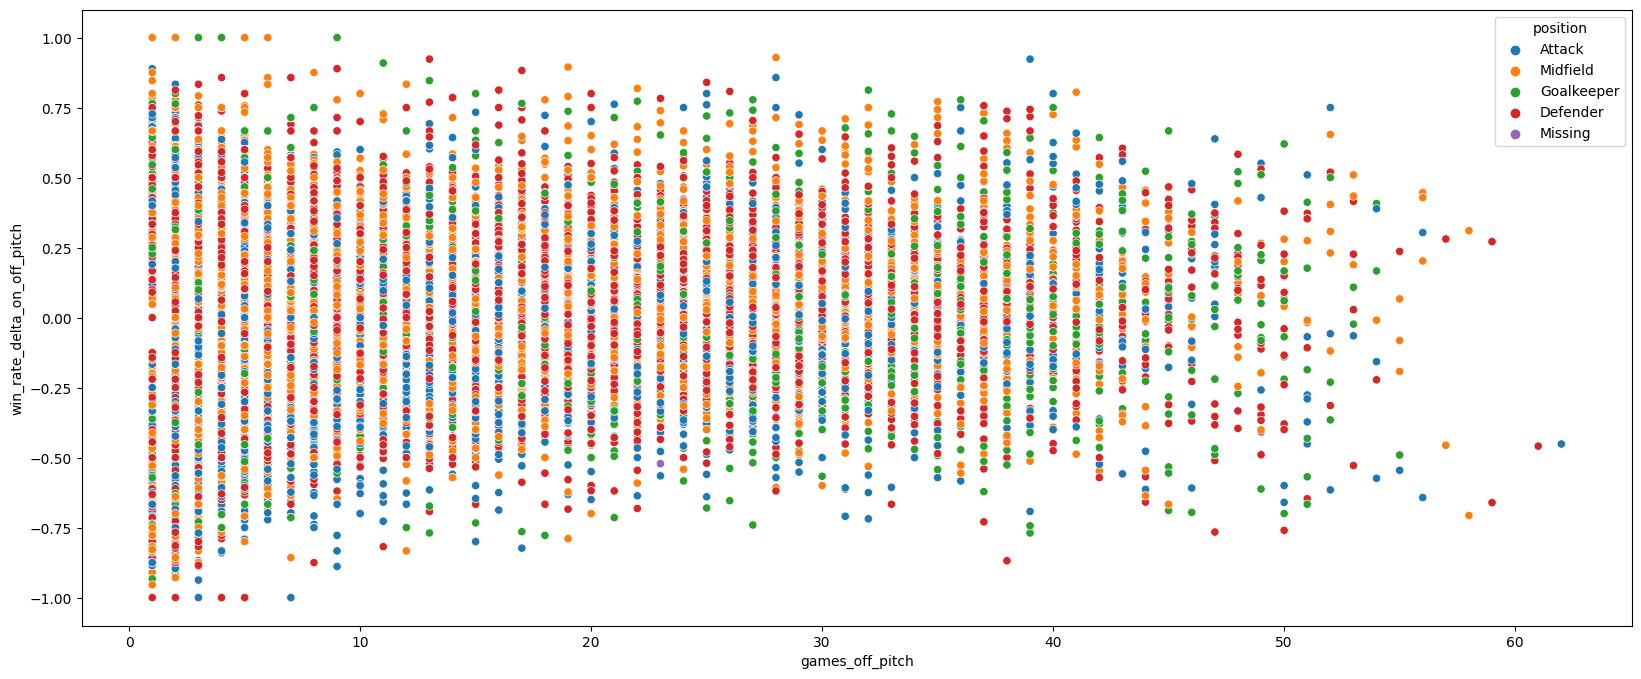

In [292]:
plt.figure(figsize=(20, 8))

sns.scatterplot(x='games_off_pitch', y='win_rate_delta_on_off_pitch',
                data=merged_results,
                hue='position' )

plt.show()

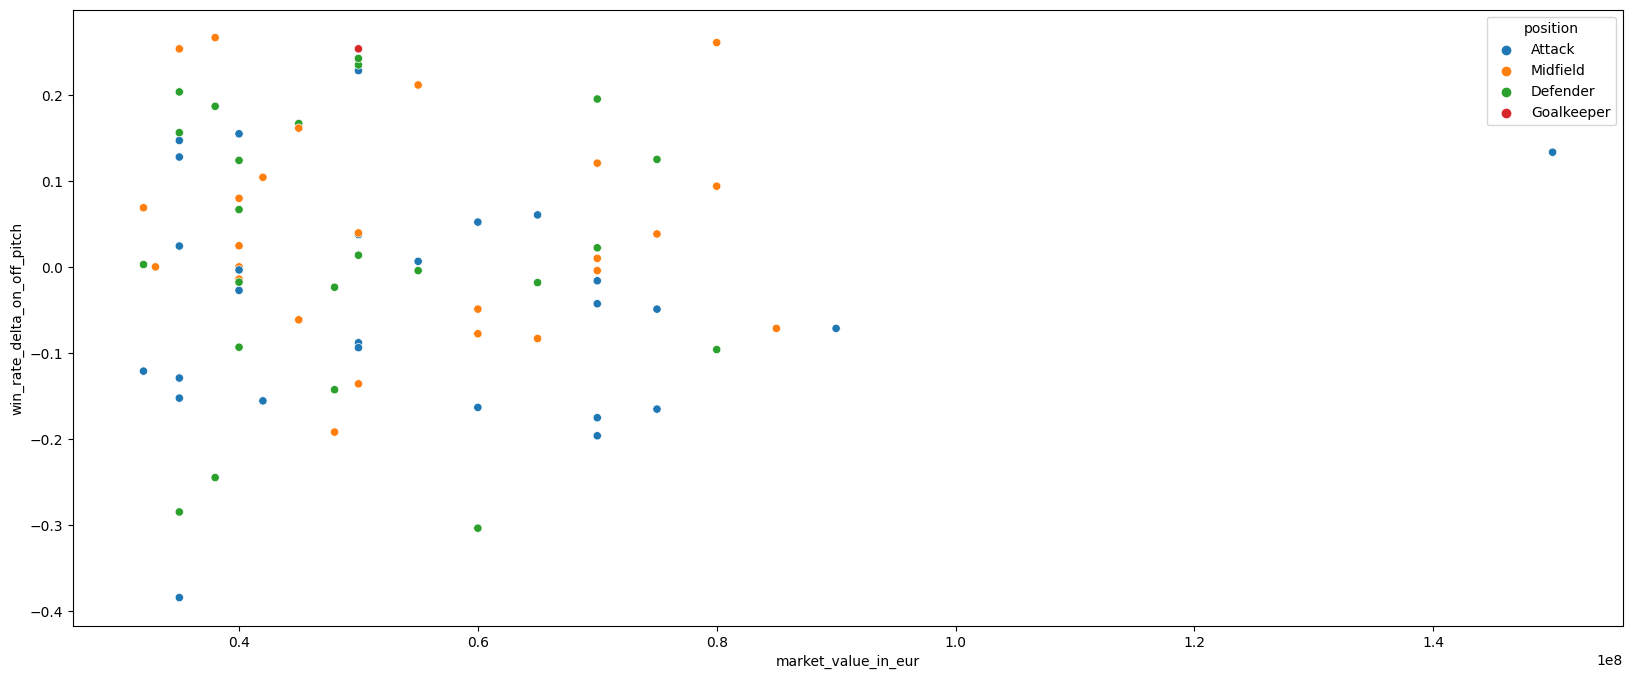

In [293]:
plt.figure(figsize=(20, 8))

sns.scatterplot(x='market_value_in_eur', y='win_rate_delta_on_off_pitch',
                data=merged_results_15_games[(merged_results_15_games["season"]==2021)&
                                            (merged_results_15_games["market_value_in_eur"]>30000000)],
                hue='position' )

plt.show()

In [294]:
merged_results_15_games[(merged_results_15_games["season"]==2020)&
                                            (merged_results_15_games["market_value_in_eur"]>50000000)][['player_id','season', 'games_on_pitch', 'games_off_pitch','win_rate_on_pitch',
                        'win_rate_off_pitch','win_rate_delta_on_off_pitch', 
                        'name', 'position', 
                        'club name', "market_value_in_eur"]].sort_values(by=['win_rate_delta_on_off_pitch'], ascending=True).head(30)

,player_id,season,games_on_pitch,games_off_pitch,win_rate_on_pitch,win_rate_off_pitch,win_rate_delta_on_off_pitch,name,position,club name,market_value_in_eur
7779,309400,2020,44,13,0.500000,0.846154,-0.346154,Kai Havertz,Midfield,Chelsea FC,70000000
18753,134425,2020,45,11,0.711111,0.909091,-0.197980,Raheem Sterling,Attack,Manchester City,90000000
15660,122153,2020,39,18,0.512821,0.666667,-0.153846,Paul Pogba,Midfield,Manchester United,60000000
3662,433177,2020,44,11,0.500000,0.636364,-0.136364,Bukayo Saka,Attack,Arsenal FC,65000000
2990,243714,2020,39,11,0.717949,0.818182,-0.100233,Kingsley Coman,Attack,Bayern Munich,65000000
26175,68290,2020,28,23,0.607143,0.695652,-0.088509,Neymar,Attack,Paris Saint-Germain,100000000
1609,225693,2020,41,10,0.512195,0.600000,-0.087805,Fabinho,Midfield,Liverpool FC,60000000
16903,182712,2020,40,16,0.725000,0.812500,-0.087500,João Cancelo,Defender,Manchester City,55000000
11770,88755,2020,36,20,0.722222,0.800000,-0.077778,Kevin De Bruyne,Midfield,Manchester City,100000000
3617,363205,2020,41,15,0.731707,0.800000,-0.068293,Gabriel Jesus,Attack,Manchester City,60000000


In [295]:
df_single_player = merged_results[merged_results["player_id"]==342229]

In [296]:
df_single_player.head()

,player_id,season,club_id,draws_in_matches_played,losses_in_matches_played,wins_in_matches_played,wins_in_matches_not_played,draws_in_matches_not_played,losses_in_matches_not_played,games_on_pitch,...,win_rate_overall,name,position,club name,country_of_birth,height_in_cm,date_of_birth,birth_year,age_in_season,market_value_in_eur
1779,342229,2015,162,5,3,4,7,3,2,12,...,0.458333,Kylian Mbappé,Attack,AS Monaco,NaN,178.0,1998-12-20,1998.0,17.0,1500000
1780,342229,2016,162,7,4,27,12,0,4,38,...,0.722222,Kylian Mbappé,Attack,AS Monaco,NaN,178.0,1998-12-20,1998.0,18.0,35000000
1781,342229,2017,162,0,1,1,0,0,0,2,...,0.500000,Kylian Mbappé,Attack,AS Monaco,NaN,178.0,1998-12-20,1998.0,19.0,150000000
1782,342229,2017,583,5,6,24,6,1,0,35,...,0.714286,Kylian Mbappé,Attack,Paris Saint-Germain,NaN,178.0,1998-12-20,1998.0,19.0,150000000
1783,342229,2018,583,5,5,27,7,1,2,37,...,0.723404,Kylian Mbappé,Attack,Paris Saint-Germain,NaN,178.0,1998-12-20,1998.0,20.0,200000000


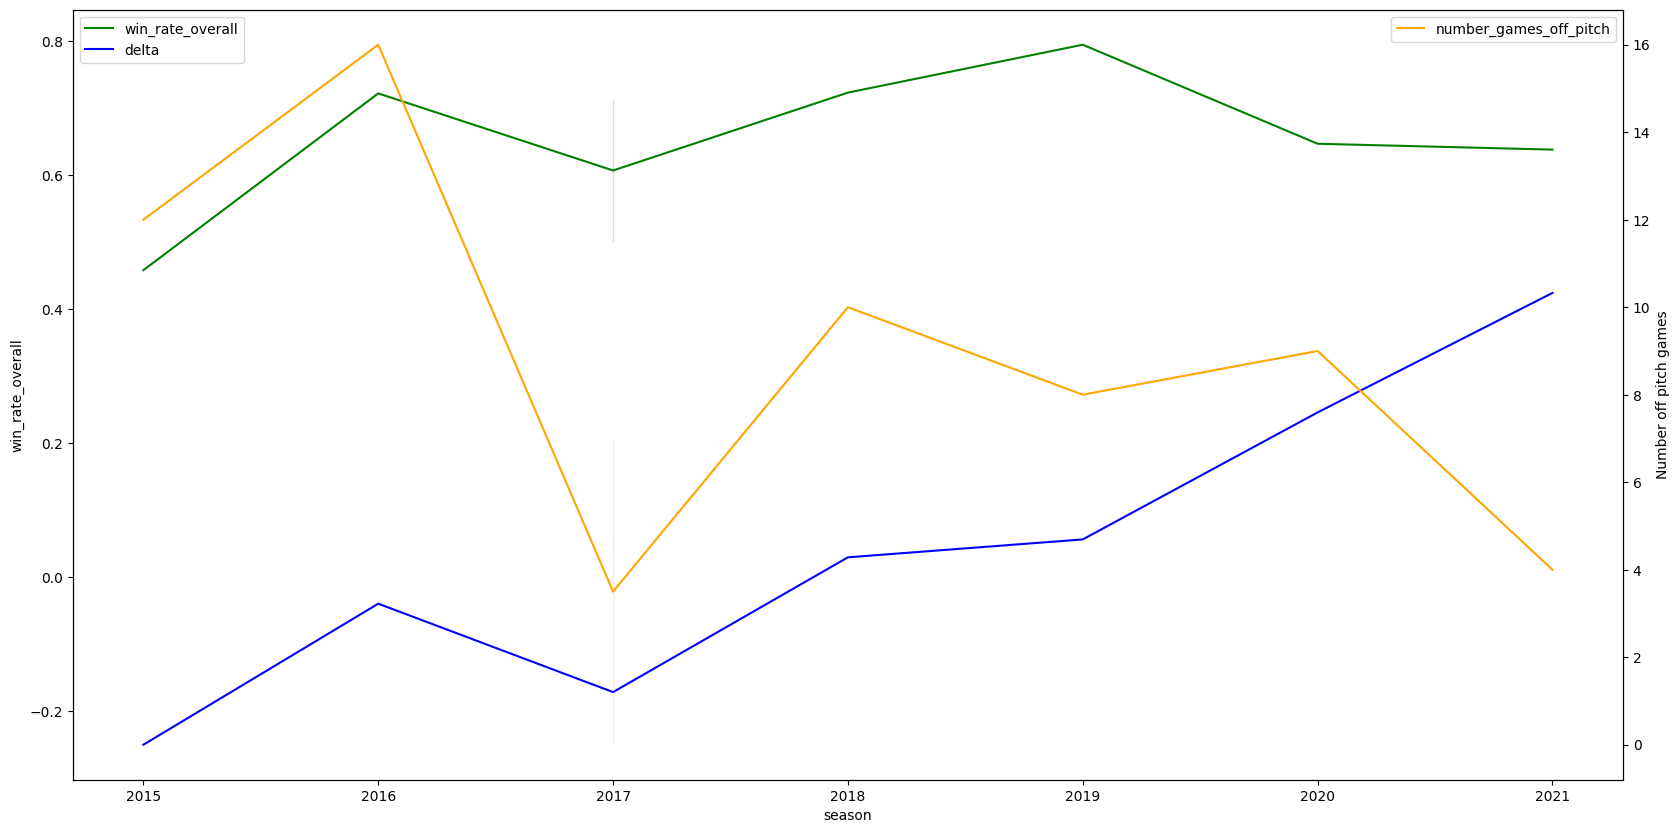

In [297]:
# Create a line plot with percentage on the left y-axis
fig, ax1 = plt.subplots(figsize=(20, 10))
sns.lineplot(x='season', y='win_rate_overall', data=df_single_player, label='win_rate_overall', ax=ax1, alpha=1, color='green')
sns.lineplot(x='season', y='win_rate_delta_on_off_pitch', data=df_single_player, label='delta', ax=ax1, alpha=1, color='blue')
# Set y-axis label for the left y-axis
ax1.set_ylabel('win_rate_overall')
# Create a bar plot with absolute numbers on the right y-axis
ax2 = ax1.twinx()
sns.lineplot(x='season', y='games_off_pitch', ax=ax2, data=df_single_player, label='number_games_off_pitch', color='orange', alpha=1)
# Set y-axis label for the right y-axis
ax2.set_ylabel('Number off pitch games')
# Show the legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
# Show the plot
plt.show()

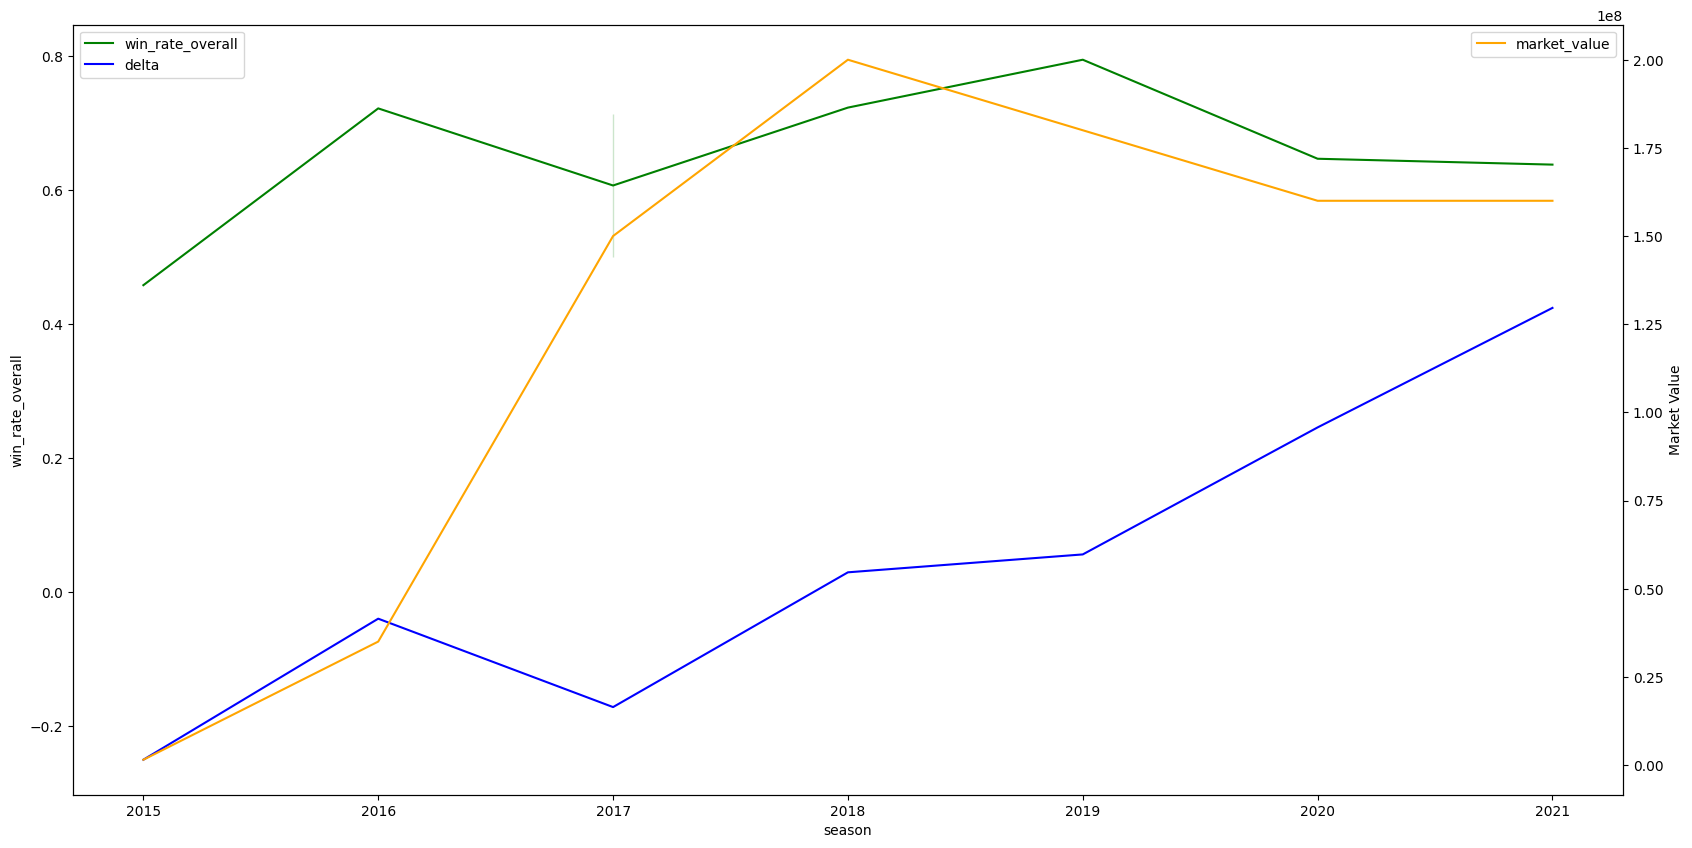

In [298]:
# Create a line plot with percentage on the left y-axis
fig, ax1 = plt.subplots(figsize=(20, 10))
sns.lineplot(x='season', y='win_rate_overall', data=df_single_player, label='win_rate_overall', ax=ax1, alpha=1, color='green')
sns.lineplot(x='season', y='win_rate_delta_on_off_pitch', data=df_single_player, label='delta', ax=ax1, alpha=1, color='blue')
# Set y-axis label for the left y-axis
ax1.set_ylabel('win_rate_overall')
# Create a bar plot with absolute numbers on the right y-axis
ax2 = ax1.twinx()
sns.lineplot(x='season', y='market_value_in_eur', ax=ax2, data=df_single_player, label='market_value', color='orange', alpha=1)

# Set y-axis label for the right y-axis
ax2.set_ylabel('Market Value')
# Show the legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
# Show the plot
plt.show()

In [299]:
merged_results.columns

Index(['player_id', 'season', 'club_id', 'draws_in_matches_played',
       'losses_in_matches_played', 'wins_in_matches_played',
       'wins_in_matches_not_played', 'draws_in_matches_not_played',
       'losses_in_matches_not_played', 'games_on_pitch', 'games_off_pitch',
       'win_rate_on_pitch', 'win_rate_off_pitch',
       'win_rate_delta_on_off_pitch', 'win_rate_overall', 'name', 'position',
       'club name', 'country_of_birth', 'height_in_cm', 'date_of_birth',
       'birth_year', 'age_in_season', 'market_value_in_eur'],
      dtype='object')

In [300]:
#calculate total win-rate delta independent of the season

merged_results_total = merged_results.groupby(['player_id', 'name']).agg(
    wins_in_matches_played=pd.NamedAgg(column='wins_in_matches_played', aggfunc='sum'),
    wins_in_matches_not_played=pd.NamedAgg(column='wins_in_matches_not_played', aggfunc='sum'),
    games_on_pitch=pd.NamedAgg(column='games_on_pitch', aggfunc='sum'),
    games_off_pitch=pd.NamedAgg(column='games_off_pitch', aggfunc='sum'),
).reset_index()

merged_results_total["win_rate_on_pitch"] = merged_results_total["wins_in_matches_played"] / merged_results_total["games_on_pitch"]
merged_results_total["win_rate_off_pitch"] = merged_results_total["wins_in_matches_not_played"] / merged_results_total["games_off_pitch"]
merged_results_total["delta"] = merged_results_total["win_rate_on_pitch"] - merged_results_total["win_rate_off_pitch"]


merged_results_total[(merged_results_total["games_on_pitch"]>50) &
                    (merged_results_total["games_off_pitch"]>30)].sort_values(by=['delta'], ascending=False).head(30)

,player_id,name,wins_in_matches_played,wins_in_matches_not_played,games_on_pitch,games_off_pitch,win_rate_on_pitch,win_rate_off_pitch,delta
4359,79045,Jeroen Zoet,164,36,255,122,0.643137,0.295082,0.348055
4038,72736,Guillaume François,48,25,67,60,0.716418,0.416667,0.299751
14642,467250,Yukhym Konoplya,50,12,78,35,0.641026,0.342857,0.298168
7769,181469,Tomas Hajek,34,24,56,77,0.607143,0.311688,0.295455
1286,27941,Danijel Subasic,105,10,196,41,0.535714,0.243902,0.291812
10723,282250,Birger Meling,48,7,93,31,0.516129,0.225806,0.290323
15851,569598,Youssouf Fofana,64,11,117,41,0.547009,0.268293,0.278716
13326,388581,Thibang Phete,24,1,79,31,0.303797,0.032258,0.271539
4504,82713,Abdullah Durak,51,8,126,59,0.404762,0.135593,0.269169
1487,31910,Felix Kroos,26,8,54,37,0.481481,0.216216,0.265265


In [301]:
df_players[df_players["last_name"]=="Mbappé"]

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,...,foot,height_in_cm,market_value_in_eur,highest_market_value_in_eur,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name
17246,342229,Kylian,Mbappé,Kylian Mbappé,2022,583,kylian-mbappe,NaN,Paris,NaN,...,right,178.0,180000000.0,200000000.0,2024-06-30 00:00:00,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/kylian-mbappe/...,FR1,Paris Saint-Germain
